In [1]:
import os 
directory = '/Users/emilyzou/Desktop/pol/pol_sep23_24_data'
output_file = 'raw_merged_23_24.txt'
content_list = []

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            content_list.append(content)

merged_content = '\n\n'.join(content_list)

with open(output_file, 'w', encoding='utf-8') as output:
    output.write(merged_content)

In [1]:
import pandas as pd
from pathlib import Path 
txt = Path ("/Users/emilyzou/Desktop/pol/raw_merged_23_24.txt").read_text()

In [2]:
txt_list = txt.split('Anonymous ID:')

In [3]:
txt_list = txt_list[1:]

In [4]:
txt_df = pd.DataFrame(txt_list, columns = ['Raw_Text'])

In [5]:
import re
def anonidget (elem): 
    return elem.split()[0] if elem else '' 
 
def date_get(s): 
    pattern = r'\b\w{3} \d{1,2} \w{3} \d{4} \d{2}:\d{2}:\d{2}\b'
    match = re.search(pattern, s)
    result = match.group(0) if match else ''
    return result 

def threadnoget (s): 
    match = re.search(r'No\.\s*(\S+)', s)
    result = match.group(1) if match else ''
    return result 

In [6]:
txt_df['Anon_Id'] = txt_df['Raw_Text'].apply(anonidget)
txt_df['Date'] = txt_df['Raw_Text'].apply(date_get)
txt_df['Thread_No'] = txt_df['Raw_Text'].apply(threadnoget)

In [7]:
def Raw_Strip (s): 
    return s['Raw_Text'].replace(s['Anon_Id'], '').replace(s['Date'], '').replace(s['Thread_No'], '').strip()

txt_df['Raw_Text'] = txt_df.apply(Raw_Strip, axis = 1)

In [8]:
def process_string(s):
    if "ViewReport\n>>" in s:
        # Extract everything after "ViewReport\n>>" and before the next "\n"
        match = re.search(r'ViewReport\n>>\s*(.*?)\n', s)
        if match:
            extracted = match.group(1)
        else:
            extracted = ""
    #elif "ViewReport\n" in s:
        #extracted = "Original Post" man this doesn't work idk why
    else:
        extracted = ""
    
    # Remove the extracted part from the original string
    s = s.replace(match.group(0) if match else "ViewReport\n", "").strip() if extracted else s
    return extracted, s

# Apply the function to the DataFrame
txt_df[['OP_ID', 'Raw_Text']] = txt_df['Raw_Text'].apply(process_string).apply(pd.Series)

In [9]:
txt_df ['Raw_Text'] = txt_df ['Raw_Text'].str.replace('ViewReport\n', '', regex=False).str[3:]

In [10]:
# stop so I can just iterate from here and not have to refill the whole dataframe

df = txt_df

In [11]:
def process_quotes(s):
    if "Quoted By" in s: 
        return re.findall(r'>>(\d+)\n', s)
    else:
        modified_string = s  # No modification needed if "Quoted By" is not present
        return "No Quote"

df['Quoted_By'] = df['Raw_Text'].apply(process_quotes)

In [12]:
def stripper (s): 
    if 'Quoted By' in s:
        cleaned_string = re.sub(r'Quoted By:|>>\d+\n', '', s)
        return cleaned_string.strip()
    else: 
        return s

df ['Raw_Text'] = df['Raw_Text'].apply(stripper)

In [13]:
_df = df.drop_duplicates(subset = ['Raw_Text', 'Anon_Id', 'Date', 'Thread_No', 'OP_ID'], keep = 'first')
_df

,Raw_Text,Anon_Id,Date,Thread_No,OP_ID,Quoted_By
0,It is related to DEI and competency crisis.\...,yFUanOPB,Sat 09 Mar 2024 20:39:26,461263750,461257045,No Quote
1,Trump will be brought in to be the face of p...,Lt8ieyIP,Sat 09 Mar 2024 20:31:51,461263238,,No Quote
2,Replies: 307 Quick Rundown:\n>DEI-gaming con...,FgT2N7yy,Sat 09 Mar 2024 20:20:31,461262420,,No Quote
3,Literally went from lets get all the top PhD...,IQ6yXVHK,Sat 09 Mar 2024 20:14:10,461262002,461260339,No Quote
4,>Hire a bunch niggers and stronk wimminz bec...,NZSRUfr4,Sat 09 Mar 2024 20:00:52,461261105,461257045,No Quote
...,...,...,...,...,...,...
27462,you guys should just make a tiktok or go pla...,o2CnyGXy,Tue 19 Mar 2024 21:44:46,462315146,,No Quote
27463,"There are no ""unwanted children."" There are ...",v2iK7B74,Tue 19 Mar 2024 21:44:42,462315138,462315021,No Quote
27464,are these judges DEI by any chance?,O+2SWXRz,Tue 19 Mar 2024 21:40:44,462314863,462314293,No Quote
27474,Replies: 5 What's up with all the glowie gov...,bzTTEyYj,Tue 19 Mar 2024 16:49:19,462293764,,No Quote


In [14]:
gf = _df

In [15]:
gf['Date'] = pd.to_datetime(gf['Date'], format='%a %d %b %Y %H:%M:%S')

# time series visualization, converting dates into week buckets
start_date = '2023-09-01'
end_date = "2024-09-30"

gf = gf[(gf['Date'] >= start_date) & (gf['Date'] <= end_date)]
gf ['Week'] = gf['Date'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_counts = gf['Week'].value_counts().reset_index()
weekly_counts.columns = ['Week', 'Count']

/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_35331/2663785028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf['Date'] = pd.to_datetime(gf['Date'], format='%a %d %b %Y %H:%M:%S')


In [16]:
weekly_counts = weekly_counts.sort_values('Week')

In [17]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
date = weekly_counts['Week'] 
value = weekly_counts ['Count']

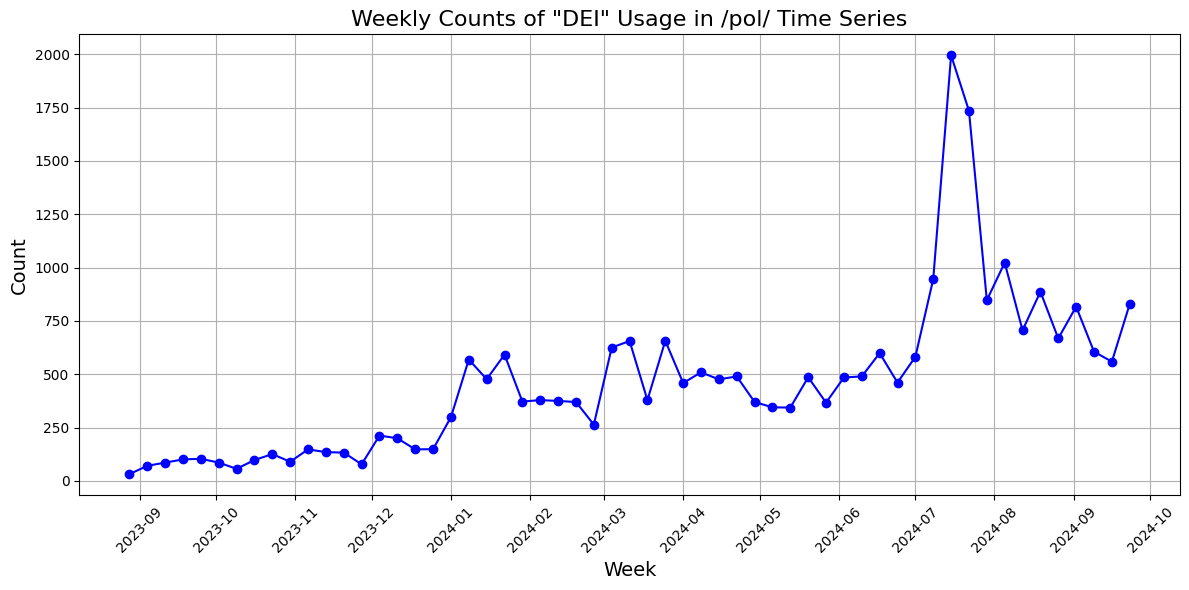

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(date, value, marker='o', linestyle='-', color='b')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adding titles and labels
plt.title('Weekly Counts of "DEI" Usage in /pol/ Time Series', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [19]:
tf = _df

In [20]:
#i should have done this earlier... 

def extract_replies(text):
    match = re.search(r'Replies:\s*(\d+)', text)
    if match:
        replies_count = int(match.group(1))
        # Remove the "Replies: digits" part from the text
        cleaned_text = re.sub(r'Replies:\s*\d+', '', text).strip()
        return replies_count, cleaned_text
    else:
        return None, text  # Return None if no match found

# Apply the function to the 'raw_text' column
tf[['Replies', 'Raw_Text']] = tf['Raw_Text'].apply(lambda x: pd.Series(extract_replies(x)))

/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_35331/3006464786.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf[['Replies', 'Raw_Text']] = tf['Raw_Text'].apply(lambda x: pd.Series(extract_replies(x)))


In [21]:
def extract_replied_to(text):
    # Find all occurrences of the pattern
    replied_to_matches = re.findall(r'>>(\d+)', text)
    # Join matches into a single string (if needed) or keep as a list
    replied_to = replied_to_matches if replied_to_matches else None
    # Remove the pattern from the original text
    cleaned_text = re.sub(r'>>\d+', '', text).strip()
    return replied_to, cleaned_text

# Apply the function to the 'raw_text' column
tf[['Replied_To', 'Raw_Text']] = tf['Raw_Text'].apply(lambda x: pd.Series(extract_replied_to(x)))


/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_35331/421163139.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf[['Replied_To', 'Raw_Text']] = tf['Raw_Text'].apply(lambda x: pd.Series(extract_replied_to(x)))


In [22]:
import nltk 
import string 
nltk.download('punkt')

tf['Raw_Tokens'] = tf['Raw_Text'].apply(nltk.word_tokenize)


def cleanlower (m): 
    return [s.lower() for s in m if s not in string.punctuation]

tf['Raw_Tokens_Lower'] = tf['Raw_Tokens'].apply(cleanlower)

[nltk_data] Downloading package punkt to /Users/emilyzou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_35331/557037197.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf['Raw_Tokens'] = tf['Raw_Text'].apply(nltk.word_tokenize)
/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_35331/557037197.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf['Raw_Tokens_Lower'] = tf['Raw_Tokens'].apply(cleanlower)


In [23]:
tf.to_csv('Oct14_Merged_Token_Dei.csv')

In [24]:
from sklearn.feature_extraction.text import CountVectorizer 

tf ['Month'] = tf['Date'].dt.to_period('M')

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(tf['Raw_Text'])

/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_35331/1951315825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf ['Month'] = tf['Date'].dt.to_period('M')


co_occurrence_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=tf['Month'])

if 'dei' in co_occurrence_df.columns:
    co_occurring_words = co_occurrence_df.loc[:, co_occurrence_df.columns != 'dei']
    co_occurring_with_DEI = co_occurring_words * co_occurrence_df['dei'].values[:, None]

    trends = co_occurring_with_DEI.groupby(co_occurrence_df.index).sum()
else:
    print('"DEI" not found in the text data.')